We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [1]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

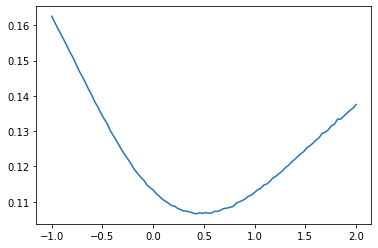

Epoch 0 with loss 0.230718195438385


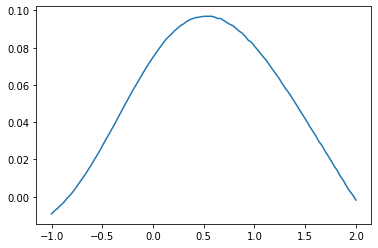

Epoch 500 with loss 0.11161911487579346


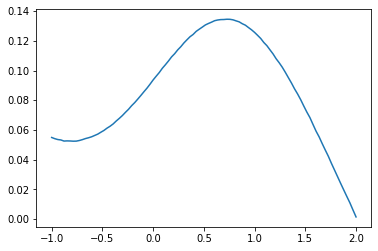

Epoch 1000 with loss 0.0993834063410759


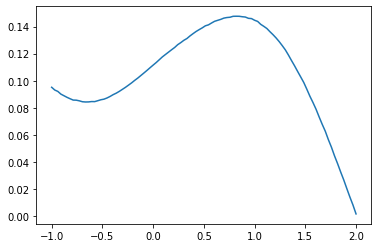

Epoch 1500 with loss 0.0873592272400856


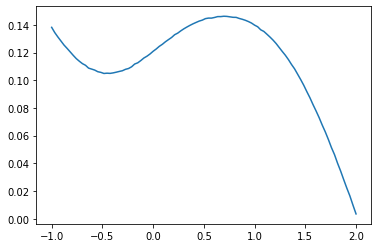

Epoch 2000 with loss 0.0836624801158905


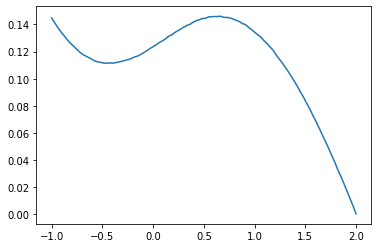

Epoch 2500 with loss 0.08048761636018753


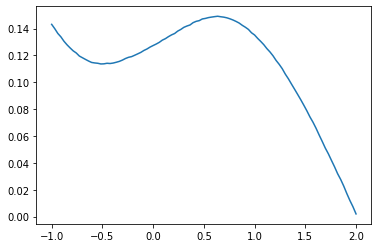

Epoch 3000 with loss 0.07308550179004669


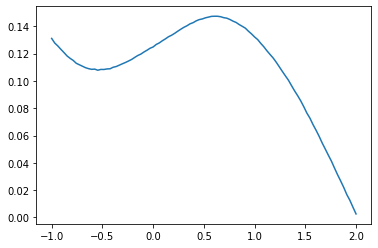

Epoch 3500 with loss 0.07102088630199432


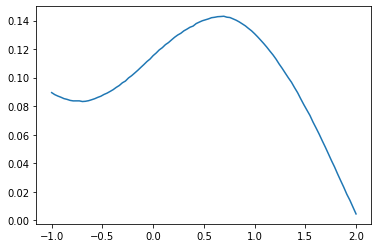

Epoch 4000 with loss 0.06966133415699005


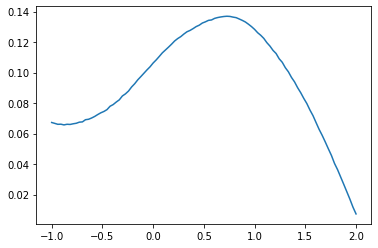

Epoch 4500 with loss 0.06436358392238617


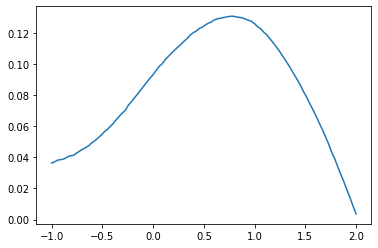

Epoch 5000 with loss 0.059449370950460434


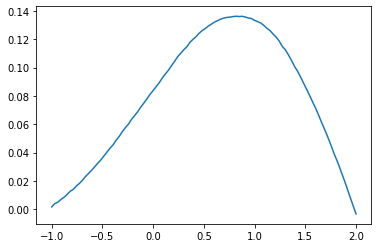

Epoch 5500 with loss 0.050833553075790405


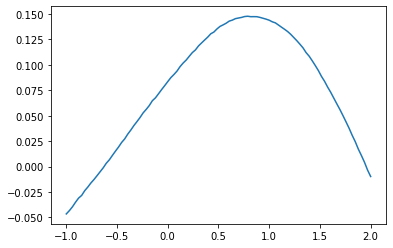

Epoch 6000 with loss 0.04130518063902855


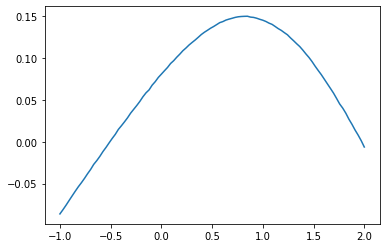

Epoch 6500 with loss 0.033678121864795685


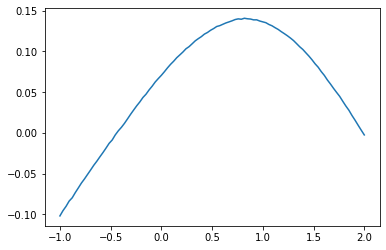

Epoch 7000 with loss 0.0274738147854805


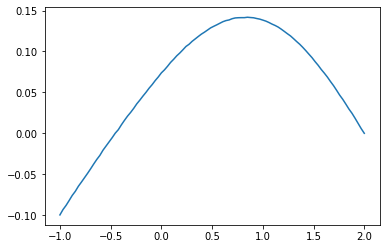

Epoch 7500 with loss 0.024350445717573166


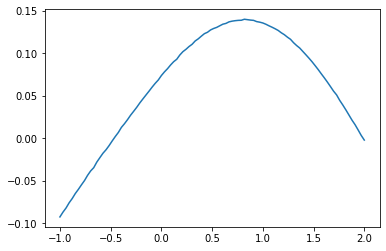

Epoch 8000 with loss 0.02070339396595955


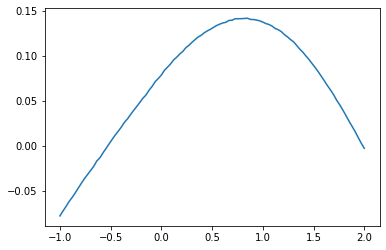

Epoch 8500 with loss 0.018720192834734917


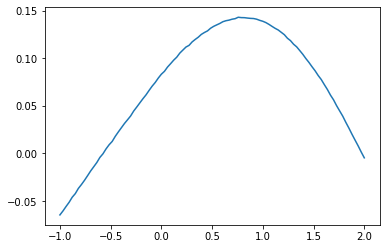

Epoch 9000 with loss 0.017777113243937492


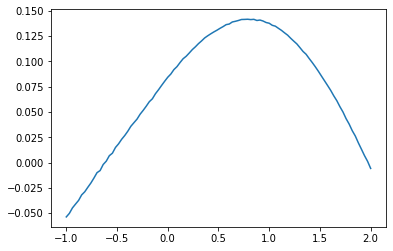

Epoch 9500 with loss 0.017572656273841858


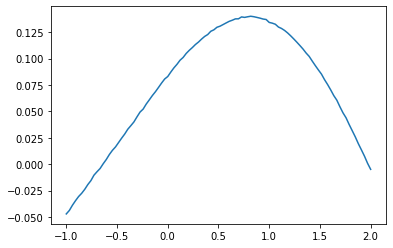

Epoch 9999 with loss 0.017232241109013557
Training of neural network with 10000 epochs take 153.8333022594452 seconds.


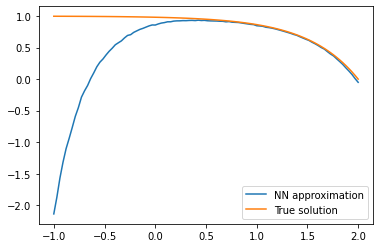

In [3]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [7]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)

Terminal loss: 0.01592819206416607
PDE loss: 0.001650331076234579
Boundary loss: 6.741541255905759e-06
